# Colorado voting analysis

This notebook looks at the correlation between county electoral party results and covid rates

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import namedtuple

In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 6.1 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8915 sha256=c21bfce62e54551bb29971b97d32aa27ecc9d0fb461a56bc0f7c51a0c0f82b39
  Stored in directory: /home/jovyan/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


We want to get the population estimates for each county as very small counties might skew the results.  This data comes from the census database.

In [3]:
dfp = pd.read_csv("Population Estimates by State.csv")

The election results of the 2020 election are used as a proxy for party affiliation. In this tables:

* delta is (percentage votes for Trump) - (percentage votes for Biden)
* votes is the number of votes in thousands

In [6]:
dfvotes = pd.read_excel('CO_2020_results_by_county.xlsx', names=['county', 'delta', 'votes'],
                        header=None, engine='openpyxl')

In [7]:
dfvotes.head()

,county,delta,votes
0,Logan,-56.0,10.5
1,Boulder,57.0,206.1
2,Prowers,-46.0,5.5
3,Cheyenne,-76.0,1.1
4,Pueblo,1.7,88.3


The covid case data is retrieved from USA Facts.

In [8]:
df = pd.read_csv('http://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
df.loc['County Name', 'Broomfield County and City'] = 'Broomfield County'

In [9]:
def get_county_data(row):
    global cases
    county = row['County Name'].replace(' County','')
    state = row.State
    ident = county + ', ' + state
    
    cases = row[4:]
    cdf = pd.DataFrame({'cases': cases, 'cpd': cases.diff()}).dropna()
    cdf.index.name = ident
    cdf['day'] = pd.to_datetime(cdf.index, format='%m/%d/%y')
    cdf['week'] = cdf.day.apply(lambda x: int(x.strftime('%U')))
    return cdf

def get_county(df, county, state):
    mask1 = df['County Name'] == county
    mask2 = df['State'] == state
    rows = df[mask1 & mask2]
    if len(rows) == 0:
        print(f'No data for county {county}')
        assert False
    
    if len(rows) == 1:
        return get_county_data(rows.iloc[0])
    elif len(rows) == 0:
        return 'No matches'
    else:
        
        return [x.State for k, x in rows.iterrows()]


In [45]:

cp = namedtuple('CountyData',['county', 'biden_lead','covid_rate','num_votes', 'party'])

def process_county(i):
    """ from county name produces voting delta, covid increase rate and number of votes """
    r = dfvotes.iloc[i]
    cname = r.county
    if cname == 'Rio Bianco':
        cname = 'Rio Blanco'
    if cname == 'Broomfield':
        cname = 'Broomfield County and City'
    else:
        cname+= ' County'
    cases = get_county(df, cname, 'CO')
    weekly = cases.groupby('week').cpd.sum()
    assert len(weekly) > 6
    m1 = weekly.iloc[-6]
    m2 = weekly.iloc[-2]
    if m1 == 0:
        return None
    gain = 100 * ((m2 / m1) - 1)
    s = f'Last Week {m1} -> {m2} ({gain:.1f}%)'
    if r.delta > 5:
        party = 'blue'
    elif r.delta < -5:
        party = 'red'
    else:
        party = 'purple'
    # print(f'{cname:20s} delta={r.delta}, {s}')
    return cp(cname, r.delta, min(gain, 500), r.votes, party)

In [46]:
x = []
y = []
s = []
c = []
for i in range(64):
    county_data = process_county(i)
    if county_data:
        x.append(county_data.biden_lead)
        y.append(county_data.covid_rate)
        s.append(county_data.num_votes)
        c.append(county_data.party)

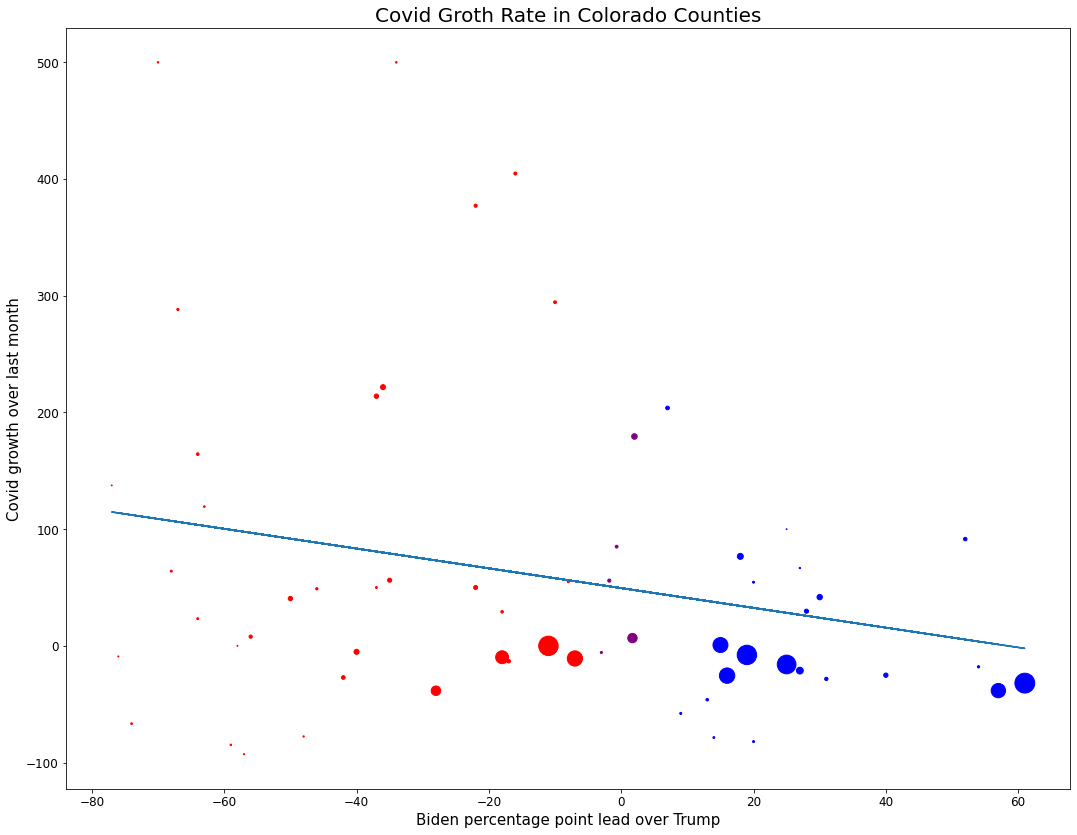

In [49]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (18, 14),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
plt.scatter(x, y, s=s, c=c);
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x))
plt.title("Covid Groth Rate in Colorado Counties", fontsize=20)
plt.xlabel("Biden percentage point lead over Trump", fontsize=15)
plt.ylabel("Covid growth over last month", fontsize=15)
plt.show()

In [48]:
np.log10(2)

0.3010299956639812

In [49]:
state = df[df['State'] == 'CO']
state

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20
251,0,Statewide Unallocated,CO,8,0,0,0,0,0,0,...,23,23,23,23,23,23,23,23,23,23
252,8001,Adams County,CO,8,0,0,0,0,0,0,...,18226,18690,19178,19705,20346,21175,21789,22149,22905,23339
253,8003,Alamosa County,CO,8,0,0,0,0,0,0,...,393,397,401,413,425,440,449,460,460,465
254,8005,Arapahoe County,CO,8,0,0,0,0,0,0,...,16332,16769,17221,17664,18205,18935,19430,19897,20549,20970
255,8007,Archuleta County,CO,8,0,0,0,0,0,0,...,73,76,76,78,80,90,94,99,101,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,8117,Summit County,CO,8,0,0,0,0,0,0,...,961,978,1023,1030,1057,1094,1116,1128,1149,1173
312,8119,Teller County,CO,8,0,0,0,0,0,0,...,317,327,333,339,357,377,391,401,413,419
313,8121,Washington County,CO,8,0,0,0,0,0,0,...,127,128,128,136,139,146,150,153,156,165
314,8123,Weld County,CO,8,0,0,0,0,0,0,...,7961,8095,8316,8587,8881,9168,9511,9844,10055,10402


In [61]:
state['County Name'][0:30]

251         Statewide Unallocated
252                  Adams County
253                Alamosa County
254               Arapahoe County
255              Archuleta County
256                   Baca County
257                   Bent County
258                Boulder County
259    Broomfield County and City
260                Chaffee County
261               Cheyenne County
262            Clear Creek County
263                Conejos County
264               Costilla County
265                Crowley County
266                 Custer County
267                  Delta County
268                 Denver County
269                Dolores County
270                Douglas County
271                  Eagle County
272                 Elbert County
273                El Paso County
274                Fremont County
275               Garfield County
276                 Gilpin County
277                  Grand County
278               Gunnison County
279               Hinsdale County
280           